In [1]:
from scipy.optimize import minimize
import numpy as np
from HVAC_utils import *

In [217]:
# T_Farenheit = 80
T_Farenheit = 60
T_outside = (T_Farenheit + 459.67)*5/9

RH_outside = 50

In [218]:
Heating_Cost = 0.0170              # unit hourly cost of heating
Cooling_Cost = 0.0333              # unit hourly cost of mechanical cooling
Ventilation_Cost = 0.0137          # unit hourly cost of ventilation
Humidification_Cost = 0.00475      # unit hourly cost of misting
Dehumidification_Cost = 0.0752     # unit hourly cost of dehumidifying
CO2_Generation_Cost = 0.339         # unit hourly cost of injecting CO2

def objective(x):
    T, RH, Ventilation_Rate, Heating_Rate, Cooling_Rate, CO2_Generation_Rate, Humidification_Rate, Dehumidification_Rate = x
    return (
        Heating_Rate*Heating_Cost + 
        Cooling_Rate*Cooling_Cost + 
        Ventilation_Rate*Ventilation_Cost +
        CO2_Generation_Rate*CO2_Generation_Cost + 
        Humidification_Rate*Humidification_Cost + 
        Dehumidification_Rate*Dehumidification_Cost
    )
    

In [219]:
Heat_From_Lights = 992;                 # [kW] heat being generated by lights
CO2_VolumeGenerated_rate = 19.865;      # [m^3/s] volume of CO2 generated per unit time

def get_internal_heat_energy(x):
    T, RH, Ventilation_Rate, Heating_Rate, Cooling_Rate, CO2_Generation_Rate, Humidification_Rate, Dehumidification_Rate = x
    
    return (
        Heat_From_Lights 
        + Heating_Rate - Cooling_Rate  
        + get_humidity_heat_energy(Humidification_Rate, Dehumidification_Rate) 
        + CO2_VolumeGenerated_rate * CO2_Generation_Rate
        + get_greenhouse_heat_energy(T,T_outside)
    )

In [220]:
Air_Heat_Capacity = 1.005               # heat capacity of air kJ/kg.K
Air_Density = 1.204                     # density of air kg/m^3

def constraint_heat(x):
    T, Ventilation_Rate = x[0],x[2]    
    
    Outflow_Heat_Energy = Air_Density*Air_Heat_Capacity*T*Ventilation_Rate
    Inflow_Heat_Energy = Air_Density*Air_Heat_Capacity*T_outside*Ventilation_Rate
    Internal_Heat_Energy = get_internal_heat_energy(x)
    
    return Outflow_Heat_Energy - (Inflow_Heat_Energy + Internal_Heat_Energy)

In [221]:
def constraint_humidity(x):
    T, RH, Ventilation_Rate = x[0:3]

    Outflow_Humidity_Energy = get_water_holding_capacity(T)*RH/100*Ventilation_Rate
    Inflow_Humidity_Energy = get_water_holding_capacity(T)*RH_Inside(T,T_outside,RH_outside)/100*Ventilation_Rate
    Internal_Humidity_Energy = get_internal_humidity_energy(x)

    return Outflow_Humidity_Energy - (Inflow_Humidity_Energy + Internal_Humidity_Energy)

In [222]:
def constraint_CO2(x):
    Ventilation_Rate, CO2_Generation_Rate = x[2], x[5]

    # CO2_Inside_Rate = 0.7368
    # CO2_Outside_Rate = 0.7368
    Plant_CO2_Absorption = 2.73;        # [g/s] used by plants

    # Outflow_CO2_Energy = CO2_Inside_Rate*Ventilation_Rate
    # Inflow_CO2_Energy = CO2_Outside_Rate*Ventilation_Rate
    # In this case Outflow_CO2_Energy = Inflow_CO2_Energy due to constant CO2 levels being maintained
    Internal_CO2_Energy = CO2_Generation_Rate - Plant_CO2_Absorption

    # return Outflow_CO2_Energy - (Inflow_CO2_Energy + Internal_CO2_Energy)
    return -Internal_CO2_Energy

In [223]:
# T, RH, CO2, Ventilation_Rate, Heating_Rate, Cooling_Rate, CO2_Generation_Rate, Humidification_Rate, Dehumidification_Rate = x
solution = minimize(
    objective,
    [0, 0, 0, 0, 0, 0, 0, 0],
    method='SLSQP',
    constraints=[
        {'type': 'eq', 'fun': constraint_heat},
        {'type': 'eq', 'fun': constraint_humidity},
        {'type': 'eq', 'fun': constraint_CO2}
    ],
    bounds=[
        ((70 + 459.67)*5/9, (71 + 459.67)*5/9), 
        (50, 80), 
        (2.675, 2.65*100), 
        (0, None), 
        (0, None), 
        (0, None), 
        (0, None), 
        (0, None)
    ]
)

In [224]:
import pandas as pd

T, RH, Ventilation_Rate, Heating_Rate, Cooling_Rate, CO2_Generation_Rate, Humidification_Rate, Dehumidification_Rate = solution.x

# Create a dataframe to store the results
results = pd.DataFrame(
    {
        'Variable': ['Temperature (F)', 'Relative Humidity (%)', 'Ventilation Rate (m^3/s)', 'Heating Rate (kW)', 'Cooling Rate (kW)', 'CO2 Generation Rate (m^3/s)', 'Humidification Rate (kW)', 'Dehumidification Rate (kW)'],
        'Value': [T*9/5 - 459.67, RH, Ventilation_Rate, Heating_Rate, Cooling_Rate, CO2_Generation_Rate, Humidification_Rate, Dehumidification_Rate]
    }
)
# For each value, calculate the cost and put it in a new column
results['Cost (in $)'] = [0,0,Ventilation_Rate*Ventilation_Cost,Heating_Rate*Heating_Cost,Cooling_Rate*Cooling_Cost,CO2_Generation_Rate*CO2_Generation_Cost,Humidification_Rate*Humidification_Cost,Dehumidification_Rate*Dehumidification_Cost]
results['Value'] = results['Value'].round(1)
results['Cost (in $)'] = results['Cost (in $)'].round(4)
# Set index to Variable and Value
results.set_index(['Variable', 'Value','Cost (in $)'], inplace=True)

print('\033[1m' + 'Selected Parameters:' + '\033[0m')
print('T Outside (F):', T_Farenheit)
print('RH Outside (%):', RH_outside)

# print optimal cost solution.fun
print('\033[1m' + 'Optimal Cost:' + '\033[0m')
print('$', round(solution.fun,4))
results

Selected Parameters:
T Outside (F): 60
RH Outside (%): 50
Optimal Cost:
$ 2.4029


,,
Variable,Value,Cost (in $)
Temperature (F),71.0,0.0000
Relative Humidity (%),53.1,0.0000
Ventilation Rate (m^3/s),45.8,0.6269
Heating Rate (kW),0.0,0.0000
Cooling Rate (kW),0.0,0.0000
CO2 Generation Rate (m^3/s),2.7,0.9255
Humidification Rate (kW),179.1,0.8505
Dehumidification Rate (kW),0.0,0.0000


In [208]:
import matplotlib.pyplot as plt

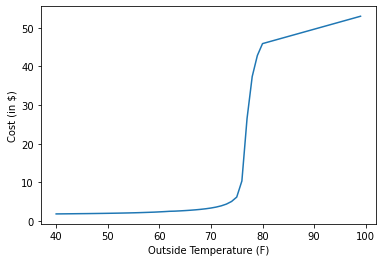

In [160]:
# For different T_Farenheit, plot the optimal cost vs. T_Farenheit
T_Farenheit_list = range(40,100)
RH_outside = 50
optimal_cost_list = []

for T_Farenheit in T_Farenheit_list:
    T_outside = (T_Farenheit + 459.67)*5/9
    solution = minimize(
        objective,
        [T_outside, RH_outside, 0, 0, 0, 0, 0, 0],
        method='SLSQP',
        constraints=[
            {'type': 'eq', 'fun': constraint_heat},
            {'type': 'eq', 'fun': constraint_humidity},
            {'type': 'eq', 'fun': constraint_CO2}
        ],
        bounds=[
            ((70 + 459.67)*5/9, (71 + 459.67)*5/9),
            (50, 80),
            (2.675, 2.65*100),
            (0, None),
            (0, None),
            (0, None),
            (0, None),
            (0, None)
        ]
    )
    optimal_cost_list.append(solution.fun)

# Create a plot
plt.plot(T_Farenheit_list, optimal_cost_list)
plt.xlabel('Outside Temperature (F)')
plt.ylabel('Cost (in $)')
plt.show()


